# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [1]:
!pip -q install ./python

from unityagents import UnityEnvironment
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import random
import copy

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [ ]:
BUFFER_SIZE = int(1e4)  
BATCH_SIZE = 128     
GAMMA = 0.99            
TAU = 1e-3             
ACTOR_LR =  1e-3      
CRITIC_LR =  1e-3                
UPDATE_EVERY = 4
NUM_UPDATES = 3
MU=0.
THETA=0.15
SIGMA=0.2

In [5]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=64):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))
    
class Critic(nn.Module):
    def __init__(self, state_size, action_size, seed, fcs1_units=128, fc2_units=64):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size+action_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units, fc2_units)
        self.bn1 = nn.BatchNorm1d(fcs1_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        xs = torch.cat((state, action.float()), dim=1)
        x = F.relu(self.fcs1(xs))
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [6]:
class OUNoise:
    def __init__(self, size, seed, mu=MU, theta=THETA, sigma=SIGMA):
        self.size=size
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        self.state = copy.copy(self.mu)

    def sample(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.size)
        self.state = x + dx
        return self.state

In [7]:
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

Multiagent - two separate actors and one shared critic.

In [8]:
class MultiAgent():

    def __init__(self, state_size, action_size, num_agents, random_seed):
        
        self.state_size = state_size
        self.action_size = action_size
        self.num_agents = num_agents
        self.seed = random.seed(random_seed)
            
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE)
        self.t_step = 0        
        self.agents = [ DDPGAgent(state_size,action_size, random_seed) for _ in range(num_agents) ]
        
        self.critic_local = Critic(state_size*num_agents, action_size*num_agents, random_seed).to(device)
        self.critic_target = Critic(state_size*num_agents, action_size*num_agents, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=CRITIC_LR)

    def act(self, states, add_noise= True):
        return [agent.act(state, add_noise) for agent, state in zip(self.agents, states)]
    
    #We need to squeez dimenzion to store in replay buffer
    def store(self,squeez):
        return np.array(squeez).reshape(1,-1).squeeze()
    
    def step(self, state, action, reward, next_state, done):
        self.memory.add(self.store(state), self.store(action), reward, self.store(next_state), done)
        
        #Every UPDATE_EVERY do NUM_UPDATES at once
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            if len(self.memory) > BATCH_SIZE:
                for _ in range(0,NUM_UPDATES):
                    for i,agent in enumerate(self.agents):
                        experiences = self.memory.sample()
                        self.learn(experiences, GAMMA, i, agent)

    #Retrieve data from buffer 
    def retrieve(self,agent_num, size,squeezed):
        return squeezed.index_select(1,torch.tensor([ i for i in range(agent_num * size, agent_num * size + size)]).to(device)) 
    
    def get_other_index(self,index):
        return 0 if index == 1 else 1

    def learn(self, experiences, gamma, agent_num, agent):
        states, actions, rewards, next_states, dones = experiences

        # Actor picks best action basically argmax in Q-learning 
        # and critic evaluates action value action using actors best believed action
        # critic sees all agents observations
        actor_next_states = self.retrieve(agent_num, self.state_size, next_states)
        adversary_next_states = self.retrieve(self.get_other_index(agent_num),self.state_size,next_states)
        next_actions = torch.cat((agent.actor_target(actor_next_states), 
                                      agent.actor_target(adversary_next_states)), dim=1).to(device) 
       
        Q_targets_next = self.critic_target(next_states, next_actions)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        Q_expected = self.critic_local(states, actions)
        
        #Critic loss
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()
        
        # to evaluate loss actor needs critic (like often people do in real life) :D
        # critic sees all agents observations
        actor_states = self.retrieve(agent_num, self.state_size, states)
        adversary_states = self.retrieve(self.get_other_index(agent_num),self.state_size,states)
        actions_pred = torch.cat((agent.actor_local(actor_states),
                                      agent.actor_local(adversary_states)), dim=1).to(device) 
        actor_loss = -self.critic_local(states, actions_pred).mean()

        agent.actor_optimizer.zero_grad()
        actor_loss.backward()
        agent.actor_optimizer.step()
        
        #Do soft update
        self.soft_update(self.critic_local, self.critic_target, TAU)
        agent.soft_update(agent.actor_local, agent.actor_target, TAU)
                     
    def reset(self):
        for agent in self.agents:
            agent.reset()
            
    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
    
    def save_weights(self):    
        torch.save(self.critic_local.state_dict(), 'critic_local.pth')
        torch.save(self.critic_target.state_dict(), 'critic_target.pth')
        for index, agent in enumerate(self.agents):
            torch.save(agent.actor_local.state_dict(), f'agent{index}_local.pth')
            torch.save(agent.actor_target.state_dict(), f'agent{index}_target.pth')

DDPG agent without critic. Critic is placed to Multiagent and shared by both agents.

In [9]:
class DDPGAgent():
    def __init__(self, state_size, action_size, random_seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=ACTOR_LR)
        
        for target, local in zip(self.actor_target.parameters(), self.actor_local.parameters()):
            target.data.copy_(local.data)
        
        self.noise = OUNoise(action_size, random_seed)
            
    def act(self, state, add_noise= True):
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample() 
        return np.clip(action, -1, 1)
                         
    def reset(self):
        self.noise.reset()
    
    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

Episode 100	Average Score: 0.0201000003
Episode 200	Average Score: 0.0000000000
Episode 300	Average Score: 0.0000000000
Episode 400	Average Score: 0.0000000000
Episode 500	Average Score: 0.0020000000
Episode 600	Average Score: 0.0159000002
Episode 700	Average Score: 0.0713000012
Episode 800	Average Score: 0.0817000013
Episode 900	Average Score: 0.0935000015
Episode 1000	Average Score: 0.0905000015
Episode 1100	Average Score: 0.0990000016
Episode 1200	Average Score: 0.1013000016
Episode 1300	Average Score: 0.0980000016
Episode 1400	Average Score: 0.1056000017
Episode 1500	Average Score: 0.1557000024
Episode 1600	Average Score: 0.1809000028
Episode 1700	Average Score: 0.2141000033
Episode 1800	Average Score: 0.2163000033
Episode 1900	Average Score: 0.3253000049
Episode 2000	Average Score: 0.3045000046
Episode 2100	Average Score: 0.3291000050
Episode 2200	Average Score: 0.2647000040
Episode 2300	Average Score: 0.2317000035
Episode 2400	Average Score: 0.1871000028
Episode 2500	Average Scor

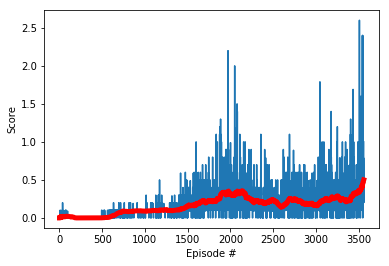

In [10]:
def ddpg2( n_episodes=5000):
    scores_window = deque(maxlen=100)  
    scores_per_episode = [] 
    average_scores_list  = []
    agent = MultiAgent(state_size, action_size, num_agents, 6)
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations 
        score = np.zeros(num_agents) 
        
        agent.reset()
        while True:
            actions = agent.act(state)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations   
            rewards = env_info.rewards   
            dones = env_info.local_done
            agent.step(state, actions, rewards, next_states, dones)            
            score += rewards
            state = next_states
            
            if np.any(dones):
                break
            
        score_max = np.max(score)
        scores_per_episode.append(score_max)
        scores_window.append(score_max)
        avg_score = np.mean(scores_window)
        average_scores_list.append(avg_score)
        
        print('\rEpisode {}\tAverage Score: {:.10f}'.format(i_episode,avg_score), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.10f}'.format(i_episode, avg_score))
        if avg_score >=0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.10f}'.format(i_episode-100, avg_score))
            agent.save_weights()
            break
    return scores_per_episode, average_scores_list

scores,avg_score = ddpg2()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.plot(np.arange(1, len(scores)+1), avg_score,'r',linewidth=5)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [11]:
env.close()
